In [35]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pywt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [36]:
base_dir = r".\Dataset_2000x5"
csv_path = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 32
SEED = 42

In [37]:
dataset_name   = os.path.basename(base_dir)
prefix_pattern = rf'^{re.escape(dataset_name)}\./'

df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False)
df['filepath'] = df['filepath'].str.replace(prefix_pattern, '', regex=True)

In [38]:
df

,filepath,label
0,original/000000000036.jpg,Original
1,salt_pepper/000000000036.jpg,Salt & Pepper
2,gaussian/000000000036.jpg,Gaussian
3,uniform/000000000036.jpg,Uniform
4,erlang/000000000036.jpg,Erlang
...,...,...
9995,original/000000581766.jpg,Original
9996,salt_pepper/000000581766.jpg,Salt & Pepper
9997,gaussian/000000581766.jpg,Gaussian
9998,uniform/000000581766.jpg,Uniform


In [39]:
# Split stratificati (stessi esempi per classe)

# 70-15-15 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 70.0%  |  Val: 15.0%  |  Test: 15.0%


In [40]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 7000 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


{'Erlang': 0, 'Gaussian': 1, 'Original': 2, 'Salt & Pepper': 3, 'Uniform': 4}

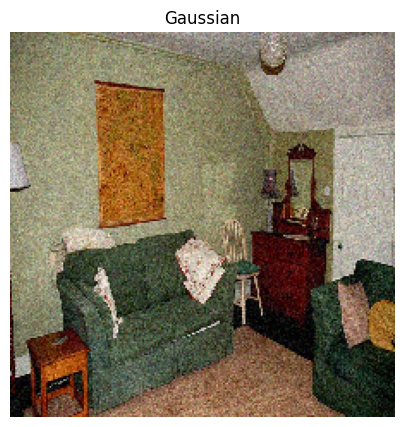

In [41]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [42]:
# 1.1 Funzione NumPy per calcolare le sub-bande DWT
def np_dwt_subbands(image):
    """
    image: array NumPy shape (H, W, 3) con valori in [0,1]
    Ritorna array float32 shape (H//2, W//2, 3) con bande LH, HL, HH.
    """
    gray = np.dot(image, [0.2989, 0.5870, 0.1140]) # Converto in grayscale con questa formula
    coeffs2 = pywt.dwt2(gray, 'haar') # Eseguo DWT livello 1 con wavelet 'haar'
    LH, HL, HH = coeffs2[1] # alte frequenze
    stacked = np.stack([LH, HL, HH], axis=-1).astype(np.float32) # Stacked bande in shape (H//2, W//2, 3)
    return stacked

def tf_dwt_subbands(x):
    """
    x: tensor di forma (batch, IMG_H, IMG_W, 3)
    Restituisce tensor di forma (batch, IMG_H//2, IMG_W//2, 3).
    """
    def _single_dwt(img):
        out = tf.numpy_function(func=lambda i: np_dwt_subbands(i),
                                inp=[img],
                                Tout=tf.float32)
        out.set_shape([IMG_H // 2, IMG_W // 2, 3])
        return out

    # Invece di passing dtype, specifichiamo fn_output_signature
    signature = tf.TensorSpec(shape=(IMG_H // 2, IMG_W // 2, 3), dtype=tf.float32)
    y = tf.map_fn(fn=_single_dwt, elems=x, fn_output_signature=signature)
    return y

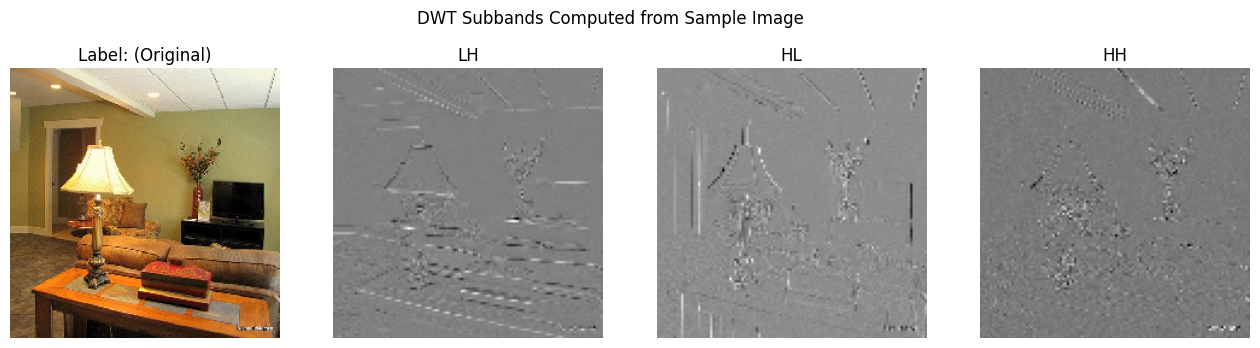

In [43]:
# Select a random index
idx = random.randint(0, train_gen.samples - 1)
img_path = train_gen.filepaths[idx]
img = load_img(img_path, target_size=(IMG_H, IMG_W))
img_arr = img_to_array(img) / 255.0

# Retrieve the actual class label of the sampled image
class_idx = train_gen.classes[idx]
inv_map = {v: k for k, v in train_gen.class_indices.items()}
label = inv_map[class_idx]

# Compute subbands
subbands_np = np_dwt_subbands(img_arr)

# Plot the original image and the computed subbands (LH, HL, HH)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axs[0].imshow(img_arr)
axs[0].set_title(f"Label: ({label})")
axs[0].axis('off')

# LH subband
axs[1].imshow(subbands_np[:, :, 0], cmap='gray')
axs[1].set_title("LH")
axs[1].axis('off')

# HL subband
axs[2].imshow(subbands_np[:, :, 1], cmap='gray')
axs[2].set_title("HL")
axs[2].axis('off')

# HH subband
axs[3].imshow(subbands_np[:, :, 2], cmap='gray')
axs[3].set_title("HH")
axs[3].axis('off')

plt.suptitle("DWT Subbands Computed from Sample Image")
plt.show()

In [ ]:
num_classes = len(train_gen.class_indices)

# 4. Definizione del modello dual-reinforced
# ============================================
input_img = layers.Input(shape=(IMG_H, IMG_W, 3), name='input_image')

# --- BRANCH WAVELET (rinforzato) ---
# 1) Calcolo on-the-fly le sub-bande LH/HL/HH
x_wave = layers.Lambda(tf_dwt_subbands, name='wavelet_subbande')(input_img)
# Now x_wave: (batch, 112, 112, 3)

# 2) Primo blocco Conv+BN+ReLU+Pool
y = layers.Conv2D(32, (3, 3), padding='same', name='conv1_wave')(x_wave)
y = layers.BatchNormalization(name='bn1_wave')(y)
y = layers.Activation('relu', name='act1_wave')(y)
y = layers.MaxPooling2D((2, 2), name='pool1_wave')(y)        # -> (56, 56, 32)

# 3) Secondo blocco Conv+BN+ReLU+Pool
y = layers.Conv2D(64, (3, 3), padding='same', name='conv2_wave')(y)
y = layers.BatchNormalization(name='bn2_wave')(y)
y = layers.Activation('relu', name='act2_wave')(y)
y = layers.MaxPooling2D((2, 2), name='pool2_wave')(y)        # -> (28, 28, 64)

# 4) Terzo blocco Conv+BN+ReLU (senza pool per mantenere un po’ di granularità)
y = layers.Conv2D(128, (3, 3), padding='same', name='conv3_wave')(y)
y = layers.BatchNormalization(name='bn3_wave')(y)
y = layers.Activation('relu', name='act3_wave')(y)
# -> (28, 28, 128)

# 5) GlobalAveragePooling + Dropout + Dense
y = layers.GlobalAveragePooling2D(name='gap_wave')(y)        # -> (128)
y = layers.Dropout(0.3, name='dropout_wave')(y)
f_wave = layers.Dense(64, activation='relu', name='fc_wave')(y)  # -> (64)

# Totale parametri stimati nel ramo wavelet:
#   conv1_wave: 32*(3*3*3) + 32 = 896  (più BN: ~128)
#   conv2_wave: 64*(3*3*32) + 64 = 18496  (più BN: ~256)
#   conv3_wave: 128*(3*3*64) + 128 = 73856 (più BN: ~512)
#   Dense(64): 128*64 + 64 = 8256
# Circa 100–110k param in totale per il ramo wavelet.

# --- BRANCH SPAZIALE (unchanged, con GAP) ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_spaz')(input_img)
x = layers.MaxPooling2D((2, 2), name='pool1_spaz')(x)         # -> (112, 112, 32)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_spaz')(x)
x = layers.MaxPooling2D((2, 2), name='pool2_spaz')(x)         # -> (56, 56, 64)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_spaz')(x)
x = layers.MaxPooling2D((2, 2), name='pool3_spaz')(x)         # -> (28, 28, 128)

f_spaz = layers.GlobalAveragePooling2D(name='gap_spaz')(x)    # -> (128)

# --- CONCATENA FEATURE E SOFTMAX ---
concat = layers.Concatenate(name='concat_spaz_wave')([f_spaz, f_wave])  # -> (128 + 64 = 192)
z = layers.Dropout(0.5, name='dropout_final')(concat)
output = layers.Dense(num_classes, activation='softmax', name='predictions')(z)

In [45]:
# Imposto batch_size per ridurre overhead cpu-gpu (cpu è il bottleneck)
BATCH = 16
train_gen.batch_size = BATCH
val_gen.batch_size   = BATCH
test_gen.batch_size  = BATCH

steps_per_epoch    = train_gen.samples // BATCH
validation_steps  = val_gen.samples // BATCH

In [ ]:
# Compilazione del modello
model = Model(inputs=input_img, outputs=output, name='NoiseClassifier_DualReinforced')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "NoiseClassifier_DualBranch"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_spaz (Conv2D)            (None, 224, 224, 32  896         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 pool1_spaz (MaxPooling2D)      (None, 112, 112, 32  0           ['conv1_spaz[0][0]']             
                                )                                        

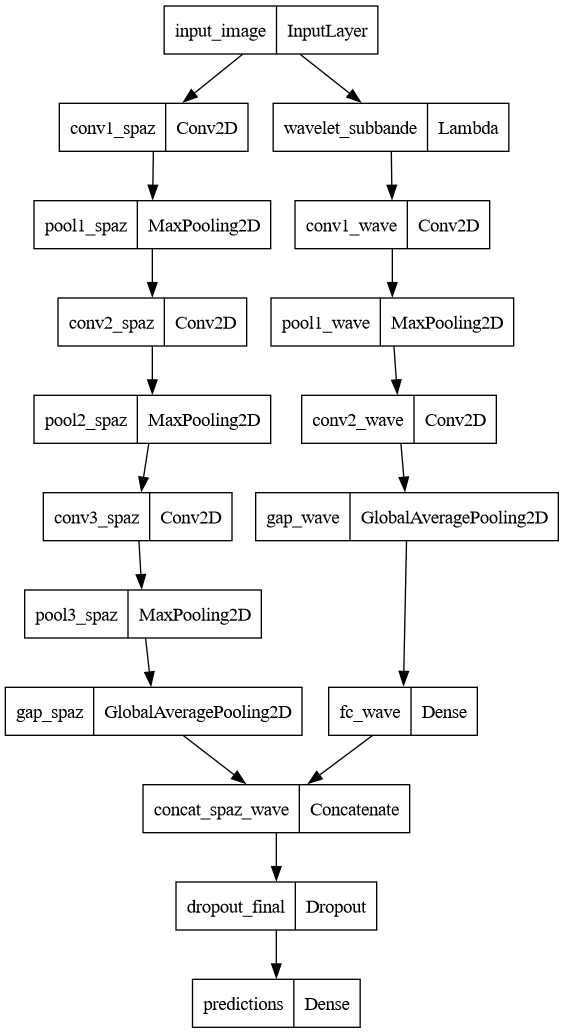

In [52]:
plot_model(model)

In [23]:
best_model = load_model('final_model.h5')

In [53]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [58]:
# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch, # numero batch in una epoch di training
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[es, mc], # Early Stopping + best model checkpoint
    workers=4, # numero thread in parallelo
    use_multiprocessing=False, # non si può
    max_queue_size=10
)

Epoch 1/50
437/437 [==============================] - 40s 91ms/step - loss: 0.4883 - accuracy: 0.8007 - val_loss: 0.4745 - val_accuracy: 0.7863
Epoch 2/50
437/437 [==============================] - 40s 92ms/step - loss: 0.4702 - accuracy: 0.7994 - val_loss: 0.4227 - val_accuracy: 0.8219
Epoch 3/50
437/437 [==============================] - 43s 98ms/step - loss: 0.4764 - accuracy: 0.7998 - val_loss: 0.4271 - val_accuracy: 0.8098
Epoch 4/50
437/437 [==============================] - 41s 94ms/step - loss: 0.4700 - accuracy: 0.8007 - val_loss: 0.4119 - val_accuracy: 0.8253
Epoch 5/50
437/437 [==============================] - 41s 94ms/step - loss: 0.4532 - accuracy: 0.8139 - val_loss: 0.4275 - val_accuracy: 0.8280
Epoch 6/50
437/437 [==============================] - 43s 97ms/step - loss: 0.4581 - accuracy: 0.8114 - val_loss: 0.4061 - val_accuracy: 0.8192
Epoch 7/50
437/437 [==============================] - 42s 96ms/step - loss: 0.4451 - accuracy: 0.8116 - val_loss: 0.4430 - val_accuracy:

In [70]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")


✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [22]:
model.save('final_model.h5')

45% accuracy con 100 immagini per classe

64.6% accuracy con 2000 immagini per classe

40% accuracy con InceptionV3 transfer learning

57% accuracy con InceptionV3 fine tuning su 100 layers

In [59]:
test_loss, test_acc = model.evaluate(test_gen)

94/94 [==============================] - 5s 50ms/step - loss: 0.2878 - accuracy: 0.8847


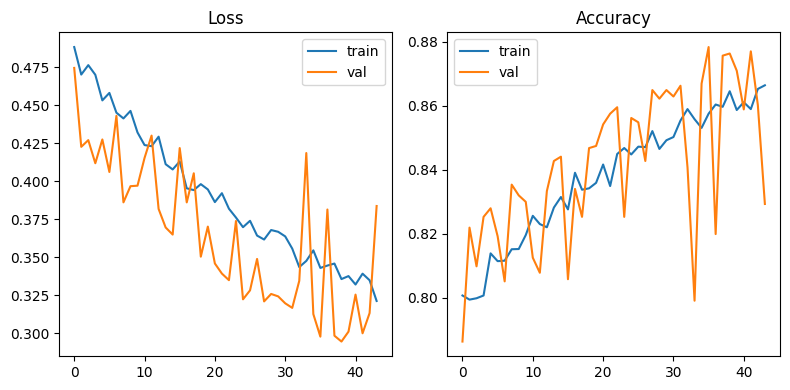

In [60]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 56ms/step


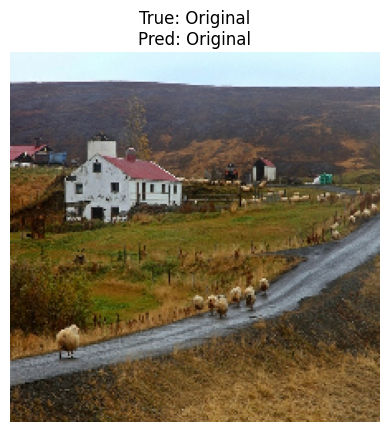

In [157]:
def show_random_prediction_tf(model, test_gen):
    """
    Seleziona un'immagine a caso dal test_gen di Keras, mostra l'immagine,
    la label effettiva e quella predetta dal modello.
    """
    # Costruisci lista di class names ordinata per indice
    class_indices = test_gen.class_indices
    class_names = [None] * len(class_indices)
    for cls, idx in class_indices.items():
        class_names[idx] = cls

    # Pesca un batch casuale
    total_batches = len(test_gen)
    batch_idx = random.randrange(total_batches)
    x_batch, y_batch = test_gen[batch_idx]

    # Pesca un campione casuale all'interno del batch
    sample_idx = random.randrange(x_batch.shape[0])
    img = x_batch[sample_idx]
    true_idx = np.argmax(y_batch[sample_idx])

    # Predizione
    preds = model.predict(img[np.newaxis, ...])
    pred_idx = np.argmax(preds[0])

    # Visualizza
    plt.imshow(img)
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}")
    plt.axis('off')
    plt.show()

# Esempio di utilizzo:
show_random_prediction_tf(model, test_gen)

In [61]:
pred_probs = model.predict(test_gen, verbose=1)

94/94 [==============================] - 5s 48ms/step


In [62]:
y_pred = np.argmax(pred_probs, axis=1) # y predicted
y_true = test_gen.classes # y actual

In [63]:
class_indices = test_gen.class_indices
class_names = [None] * len(class_indices)
for cls, idx in class_indices.items():
    class_names[idx] = cls

print(class_names)

['Erlang', 'Gaussian', 'Original', 'Salt & Pepper', 'Uniform']


In [64]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

               precision    recall  f1-score   support

       Erlang       0.96      0.93      0.94       300
     Gaussian       0.76      0.73      0.75       300
     Original       0.99      0.97      0.98       300
Salt & Pepper       0.99      1.00      1.00       300
      Uniform       0.73      0.80      0.77       300

     accuracy                           0.88      1500
    macro avg       0.89      0.88      0.89      1500
 weighted avg       0.89      0.88      0.89      1500



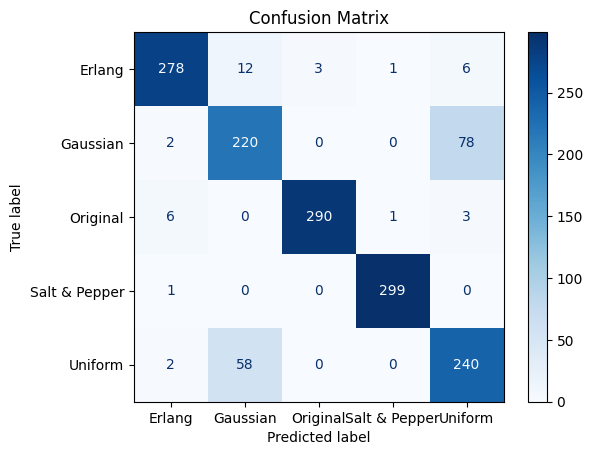

In [65]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# PROBLEMA: il modello predice "Uniform" troppo spesso (anche se il rumore è Gaussian o Erlang)